# Quarry Production and Downtime EDA

The following data is collected from a limestone quarry. We can assume that under ideal conditions, downtime is minimized and material is blasted, moved, processed, and shipped 24/7. The purpose of this notebook is to investigate two sets of data:

(1) Daily Total Production (Tonnes)

(2) Downtime Events

In [48]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Load CSVs
dfprod = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfprod.csv")
dfdown = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfdown.csv")

### Inspect Dataframes and Change Data Types

First change production data types

In [50]:
dfprod.head()

,Date,Actual Tonnage
0,2024-01-01,0
1,2024-01-02,"6,267"
2,2024-01-03,"21,831"
3,2024-01-04,"17,462"
4,2024-01-05,"18,090"


In [51]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            329 non-null    object
 1   Actual Tonnage  329 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


In [52]:
# Convert features to useful data types
dfprod["Date"] = pd.to_datetime(dfprod["Date"])
dfprod["Actual Tonnage"] = dfprod["Actual Tonnage"].str.replace(',', '').astype(int)

Next, change downtime data types as required

In [53]:
dfdown.head()

,Date,Downtime Description,Start Time [24:00],End Time [24:00],Downtime Category,Duration (minutes),D_Change produced material,D_Electrical/Mechanical,D_Lack of feed,D_Meetings/Breaks/Training,D_Planned Maintenance,D_Production Stoppage,D_Rate loss,D_Start up/Shut Down,D_Weather/Environmental
0,2024-01-04,SAFETY TALK,2024-01-04 00:00:00,2024-01-04 00:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
1,2024-01-04,CC AND TRAVEL,2024-01-04 00:15:00,2024-01-04 00:45:00,Start up/Shut Down,30,False,False,False,False,False,False,False,True,False
2,2024-01-04,LUNCH,2024-01-04 04:30:00,2024-01-04 05:15:00,Meetings/Breaks/Training,45,False,False,False,True,False,False,False,False,False
3,2024-01-04,SAFETY TALK,2024-01-04 08:00:00,2024-01-04 08:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
4,2024-01-04,CC AND TRAVEL,2024-01-04 08:15:00,2024-01-04 08:30:00,Start up/Shut Down,15,False,False,False,False,False,False,False,True,False


In [54]:
dfdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        5822 non-null   object
 1   Downtime Description        5822 non-null   object
 2   Start Time [24:00]          5811 non-null   object
 3   End Time [24:00]            5810 non-null   object
 4   Downtime Category           5817 non-null   object
 5   Duration (minutes)          5822 non-null   int64 
 6   D_Change produced material  5822 non-null   bool  
 7   D_Electrical/Mechanical     5822 non-null   bool  
 8   D_Lack of feed              5822 non-null   bool  
 9   D_Meetings/Breaks/Training  5822 non-null   bool  
 10  D_Planned Maintenance       5822 non-null   bool  
 11  D_Production Stoppage       5822 non-null   bool  
 12  D_Rate loss                 5822 non-null   bool  
 13  D_Start up/Shut Down        5822 non-null   bool

There appear to be a few null values as these are manually entered records.

In [55]:
# Convert features to useful data types
dfdown["Date"] = pd.to_datetime(dfdown["Date"])
dfdown["Start Time [24:00]"] = pd.to_datetime(dfdown["Start Time [24:00]"])
dfdown["End Time [24:00]"] = pd.to_datetime(dfdown["End Time [24:00]"])
dfdown["Duration (minutes)"] = dfdown["Duration (minutes)"].astype(int)

### Observations and Exploration

Lets first take a look at the production dataframe. Descriptive information will give a useful overview.

In [56]:
dfprod.describe()

,Date,Actual Tonnage
count,329,329.000000
mean,2024-06-13 00:00:00,11035.188450
min,2024-01-01 00:00:00,0.000000
25%,2024-03-23 00:00:00,4843.000000
50%,2024-06-13 00:00:00,12322.000000
75%,2024-09-03 00:00:00,17481.000000
max,2024-11-24 00:00:00,23927.000000
std,NaN,7449.202362


In [57]:
print((dfprod["Actual Tonnage"] == 0).sum())

68


From the information above, we can see that there are no negative values (although there are a fair number of zeros). How does the production trend look?

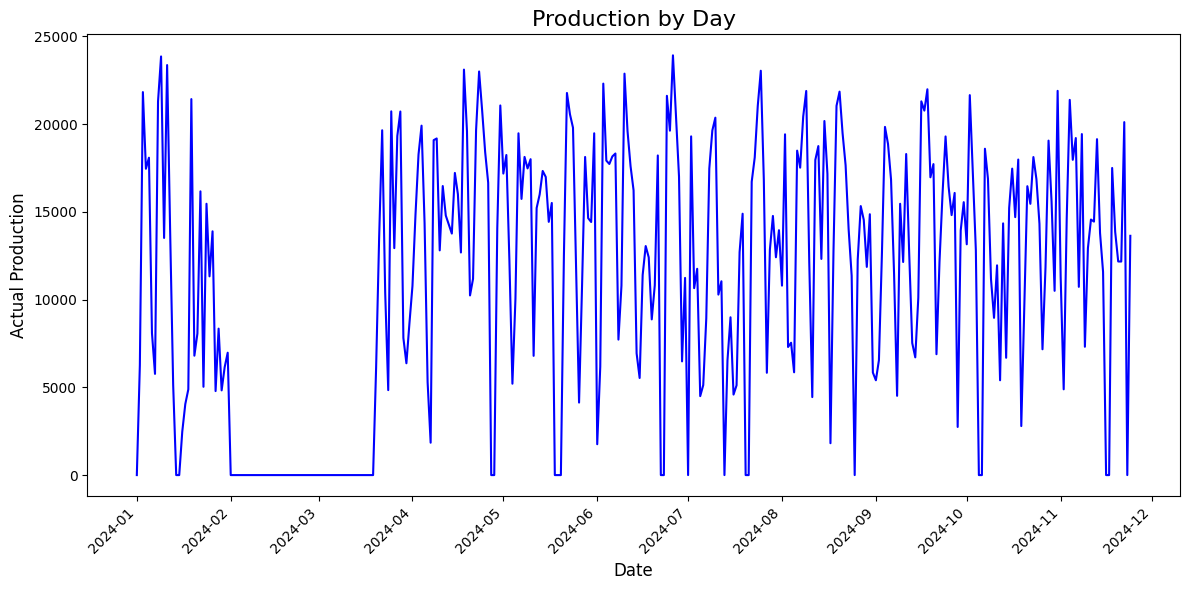

In [58]:
plt.figure(figsize=(12,6))
sns.lineplot(
    x="Date",
    y="Actual Tonnage",
    data=dfprod,
    color="blue"
)
plt.title("Production by Day", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Actual Production", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()
plt.show()



As observed above, there is a large break during the winter shutdown then continued production throught the year. There are also a number of days where the plant appears to not be running (or is potentailly experiencing a downtime event).

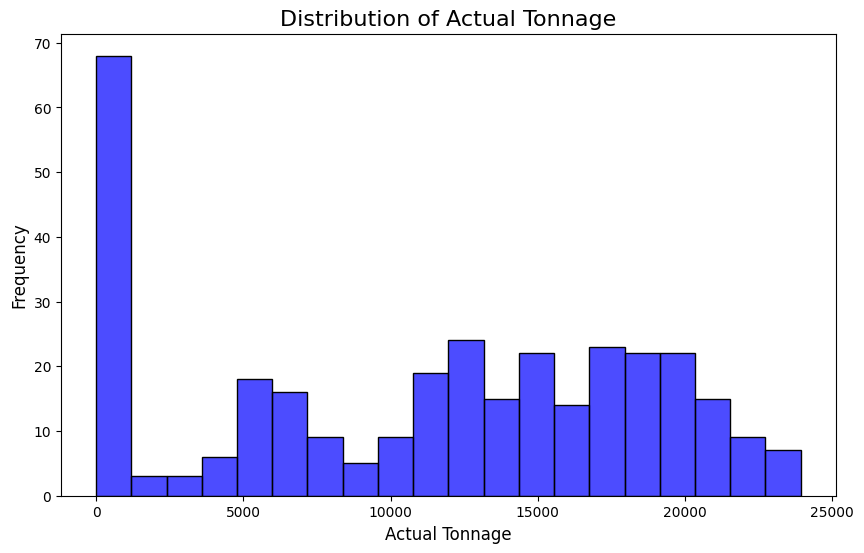

In [59]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(dfprod["Actual Tonnage"], bins=20, color="blue", alpha=0.7)
plt.title("Distribution of Actual Tonnage", fontsize=16)
plt.xlabel("Actual Tonnage", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


From the histogram, we see a large number of low (effectivly zero) production days and semi-uniform distribution (with lots of variance).

Let's now take a look at downtime.

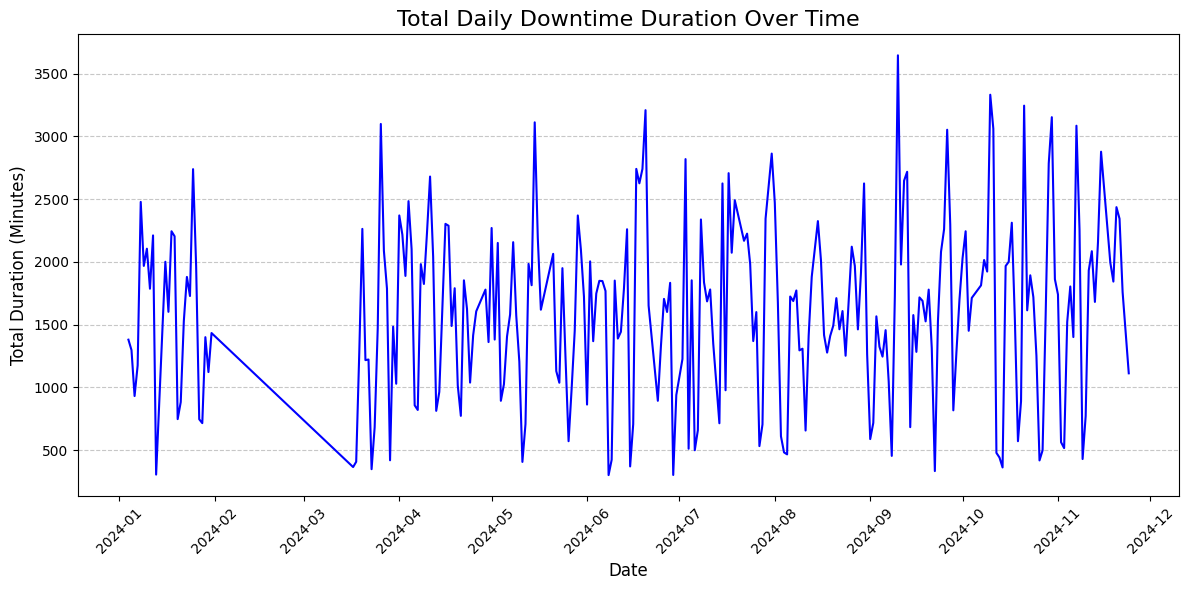

In [60]:
# Group by "Date" and sum the downtime durations
daily_downtime = dfdown.groupby("Date")["Duration (minutes)"].sum().reset_index()

# Plot the trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_downtime, x="Date", y="Duration (minutes)", color="blue")
plt.title("Total Daily Downtime Duration Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Duration (Minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

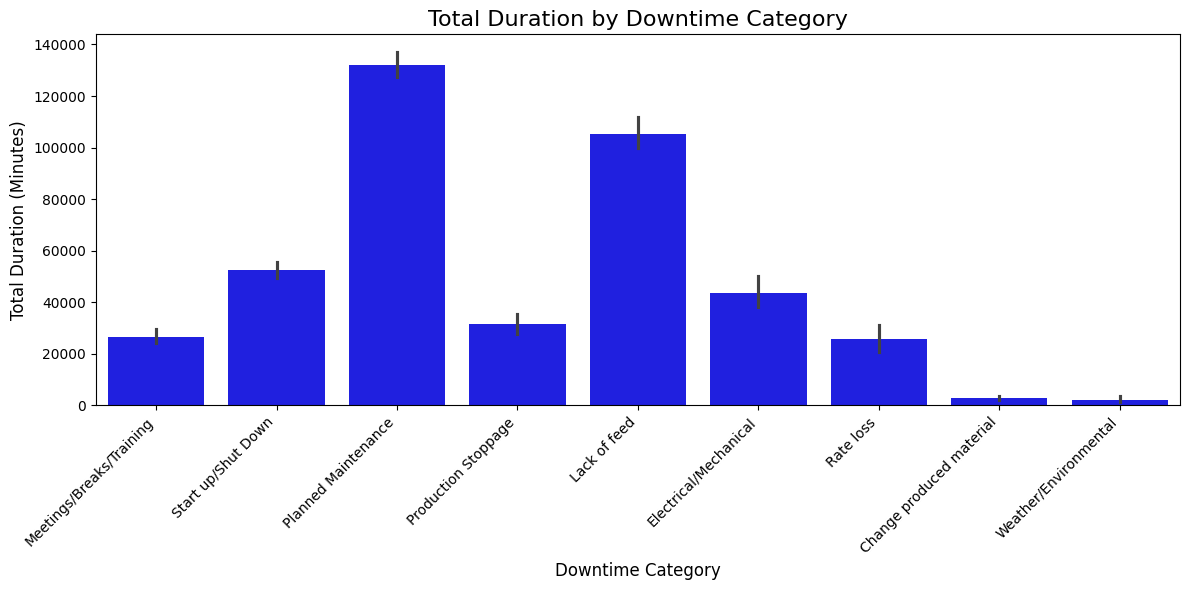

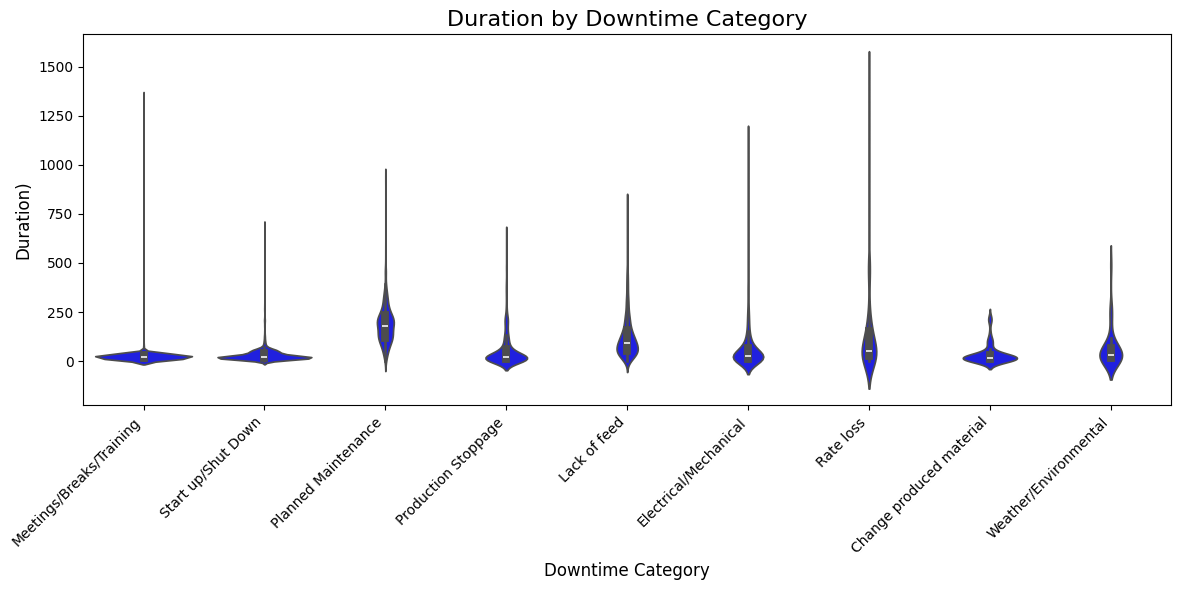

In [61]:
# Observing catagory sums

# Barplot of Downtime Category vs. Duration
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Downtime Category", 
    y="Duration (minutes)", 
    data=dfdown, 
    estimator=sum,  # Summing durations for each category
    color="blue"
)
plt.title("Total Duration by Downtime Category", fontsize=16)
plt.xlabel("Downtime Category", fontsize=12)
plt.ylabel("Total Duration (Minutes)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(
    x="Downtime Category", 
    y="Duration (minutes)", 
    data=dfdown, 
    color="blue"
)
plt.title("Duration by Downtime Category", fontsize=16)
plt.xlabel("Downtime Category", fontsize=12)
plt.ylabel("Duration)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()
plt.show()

Interestingly, we can observe that most of the lost downtime is from planned maintenance or lack of feed (no material coming into the processing plant due to some stoppage earlier in the process).

### Modeling and Inference

For prediction, lets remove the scheduled zero production days from our data set. We are only concerned with production figures when we plan on running the plant. We will remove all rows in dfprod where 'Actual Tonnage' == 0 and there are no listed downtime events (implying that the plant was not supposed to be running)

In [62]:
dfprod = dfprod[(dfprod["Actual Tonnage"] != 0) & (dfprod["Date"].isin(dfdown["Date"]))]

dfprod.describe()

,Date,Actual Tonnage
count,259,259.000000
mean,2024-07-03 10:33:49.343629312,13909.185328
min,2024-01-04 00:00:00,1759.000000
25%,2024-04-29 12:00:00,10443.500000
50%,2024-07-09 00:00:00,14449.000000
75%,2024-09-15 12:00:00,18150.000000
max,2024-11-24 00:00:00,23927.000000
std,NaN,5442.300395


Let's also make sure to remove any downtime events/days with missing values.

In [63]:
# Drop rows with NaN values in dfdown
dfdown_cleaned = dfdown.dropna()

# Identify the dates to exclude from dfprod
dates_to_exclude = dfdown[~dfdown.index.isin(dfdown_cleaned.index)]["Date"].unique()

# Remove rows in dfprod with matching dates
dfprod_cleaned = dfprod[~dfprod["Date"].isin(dates_to_exclude)]


Observe general trends